# 02 - Feature Engineering Analysis

## Objective: Reduce 117 features to a smaller, interpretable set

### Strategy:
1. **Correlation Analysis**: Identify highly correlated feature groups
2. **UMAP Feature Projection**: Visualize which features cluster together
3. **Discriminative Power**: Which features best separate the phenotypes?
4. **Final Selection**: Create curated ~15-25 feature set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
%matplotlib inline

RANDOM_STATE = 42

---
## 1. Load Features and Define Categories

In [2]:
# Load features
features_df = pd.read_csv('../output/test_features.csv')

# Identify feature columns
id_col = 'ID'
feature_cols = [c for c in features_df.columns 
                if c != id_col and features_df[c].dtype in ['float64', 'int64', 'float32', 'int32']]

# Remove high-missing features
missing_pct = features_df[feature_cols].isna().mean()
valid_features = missing_pct[missing_pct < 0.2].index.tolist()

print(f"Total features: {len(feature_cols)}")
print(f"Features with <20% missing: {len(valid_features)}")

Total features: 116
Features with <20% missing: 110


In [3]:
# Define feature categories based on extractors
FEATURE_CATEGORIES = {
    'burden_core': [
        'total_af_minutes', 'total_af_hours', 'total_af_days',
        'af_burden_percent', 'af_burden_rate_per_day', 'af_burden_rate_per_week',
        'follow_up_days'
    ],
    'burden_windowed': [
        'burden_minutes_0_30d', 'burden_rate_0_30d',
        'burden_minutes_30_90d', 'burden_rate_30_90d', 
        'burden_minutes_90_180d', 'burden_rate_90_180d',
        'burden_minutes_180_365d', 'burden_rate_180_365d',
        'burden_first_30d', 'burden_after_30d',
        'burden_first_half', 'burden_second_half',
        'burden_ratio_second_first',
        'burden_q1', 'burden_q2', 'burden_q3', 'burden_q4'
    ],
    'episode_core': [
        'n_episodes', 'episode_rate_per_week', 'episode_rate_per_month',
        'mean_episode_duration', 'median_episode_duration',
        'max_episode_duration', 'min_episode_duration'
    ],
    'episode_stats': [
        'std_episode_duration', 'cv_episode_duration', 'skew_episode_duration',
        'duration_p25', 'duration_p75', 'duration_p90', 'duration_iqr',
        'pct_episodes_lt_1h', 'pct_episodes_1h_24h', 
        'pct_episodes_gt_24h', 'pct_episodes_gt_7d',
        'n_episodes_gt_1h', 'n_episodes_gt_24h'
    ],
    'episode_intervals': [
        'mean_inter_episode_interval', 'median_inter_episode_interval',
        'min_inter_episode_interval', 'max_inter_episode_interval',
        'std_inter_episode_interval', 'cv_inter_episode_interval',
        'burstiness_index', 'pct_intervals_lt_1d', 'pct_intervals_lt_7d',
        'fano_factor_weekly'
    ],
    'temporal_daynight': [
        'n_daytime_episodes', 'n_nighttime_episodes',
        'pct_daytime_episodes', 'day_night_ratio',
        'burden_pct_daytime', 'burden_pct_nighttime'
    ],
    'temporal_circadian': [
        'peak_hour', 'hourly_concentration',
        'hourly_entropy', 'hourly_entropy_normalized'
    ],
    'temporal_weekly': [
        'pct_weekend_episodes', 'weekday_weekend_ratio',
        'dow_entropy', 'dow_entropy_normalized', 'monthly_entropy'
    ],
    'rr_core': [
        'mean_rr_interval', 'median_rr_interval',
        'mean_ventricular_rate', 'median_ventricular_rate'
    ],
    'rr_variability': [
        'std_rr_interval', 'cv_rr_interval', 'range_rr_interval',
        'min_rr_interval', 'max_rr_interval',
        'std_ventricular_rate', 'min_ventricular_rate', 'max_ventricular_rate'
    ],
    'rr_categories': [
        'pct_rapid_af', 'pct_controlled_af', 'pct_slow_af', 'pct_very_rapid_af',
        'n_episodes_with_rr', 'pct_episodes_with_rr',
        'duration_weighted_mean_rr', 'rr_duration_correlation'
    ],
    'trajectory_slope': [
        'trajectory_slope', 'trajectory_intercept', 'trajectory_r_squared',
        'trajectory_quadratic_coef', 'trajectory_linear_coef', 'trajectory_convexity'
    ],
    'trajectory_segments': [
        'slope_q1', 'slope_q2', 'slope_q3', 'slope_q4', 'slope_change_ratio'
    ],
    'trajectory_shape': [
        'has_plateau', 'longest_plateau_episodes', 'plateau_onset_days',
        'n_major_steps', 'max_step_size_minutes', 'max_step_size_pct',
        'top3_episode_contribution_pct', 'trajectory_auc_normalized'
    ]
}

# Count features per category
print("\nFeature Categories:")
print("=" * 50)
for cat, feats in FEATURE_CATEGORIES.items():
    available = [f for f in feats if f in valid_features]
    print(f"{cat}: {len(available)}/{len(feats)} available")


Feature Categories:
burden_core: 7/7 available
burden_windowed: 17/17 available
episode_core: 7/7 available
episode_stats: 13/13 available
episode_intervals: 10/10 available
temporal_daynight: 6/6 available
temporal_circadian: 4/4 available
temporal_weekly: 5/5 available
rr_core: 4/4 available
rr_variability: 8/8 available
rr_categories: 8/8 available
trajectory_slope: 6/6 available
trajectory_segments: 0/5 available
trajectory_shape: 6/8 available


In [4]:
# Prepare feature matrix
X = features_df[valid_features].copy()
X = X.replace([np.inf, -np.inf], np.nan)

# Fill missing with median
for col in X.columns:
    median_val = X[col].median()
    if pd.isna(median_val):
        median_val = 0
    X[col] = X[col].fillna(median_val)

# Clip extreme values
for col in X.columns:
    q99 = X[col].quantile(0.99)
    q01 = X[col].quantile(0.01)
    X[col] = X[col].clip(lower=q01, upper=q99)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled_df = pd.DataFrame(X_scaled, columns=valid_features)

print(f"Feature matrix: {X_scaled.shape}")

Feature matrix: (246, 110)


---
## 2. Correlation Analysis

In [5]:
# Calculate correlation matrix
corr_matrix = X_scaled_df.corr()

# Find highly correlated pairs (|r| > 0.9)
high_corr_pairs = []
for i, col1 in enumerate(valid_features):
    for j, col2 in enumerate(valid_features):
        if i < j:
            corr = corr_matrix.loc[col1, col2]
            if abs(corr) > 0.9:
                high_corr_pairs.append({
                    'feature1': col1,
                    'feature2': col2,
                    'correlation': corr
                })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)

print(f"Feature pairs with |correlation| > 0.9: {len(high_corr_df)}")
print("\nTop 20 highly correlated pairs:")
display(high_corr_df.head(20))

Feature pairs with |correlation| > 0.9: 89

Top 20 highly correlated pairs:


,feature1,feature2,correlation
52,episode_rate_per_week,episode_rate_per_month,1.0
37,burden_minutes_90_180d,burden_rate_90_180d,1.0
34,burden_minutes_0_30d,burden_first_30d,1.0
33,burden_minutes_0_30d,burden_rate_0_30d,1.0
36,burden_minutes_30_90d,burden_rate_30_90d,1.0
35,burden_rate_0_30d,burden_first_30d,1.0
38,burden_minutes_180_365d,burden_rate_180_365d,1.0
28,af_burden_rate_per_day,af_burden_rate_per_week,1.0
0,total_af_minutes,total_af_hours,1.0
61,max_episode_duration,max_step_size_minutes,1.0


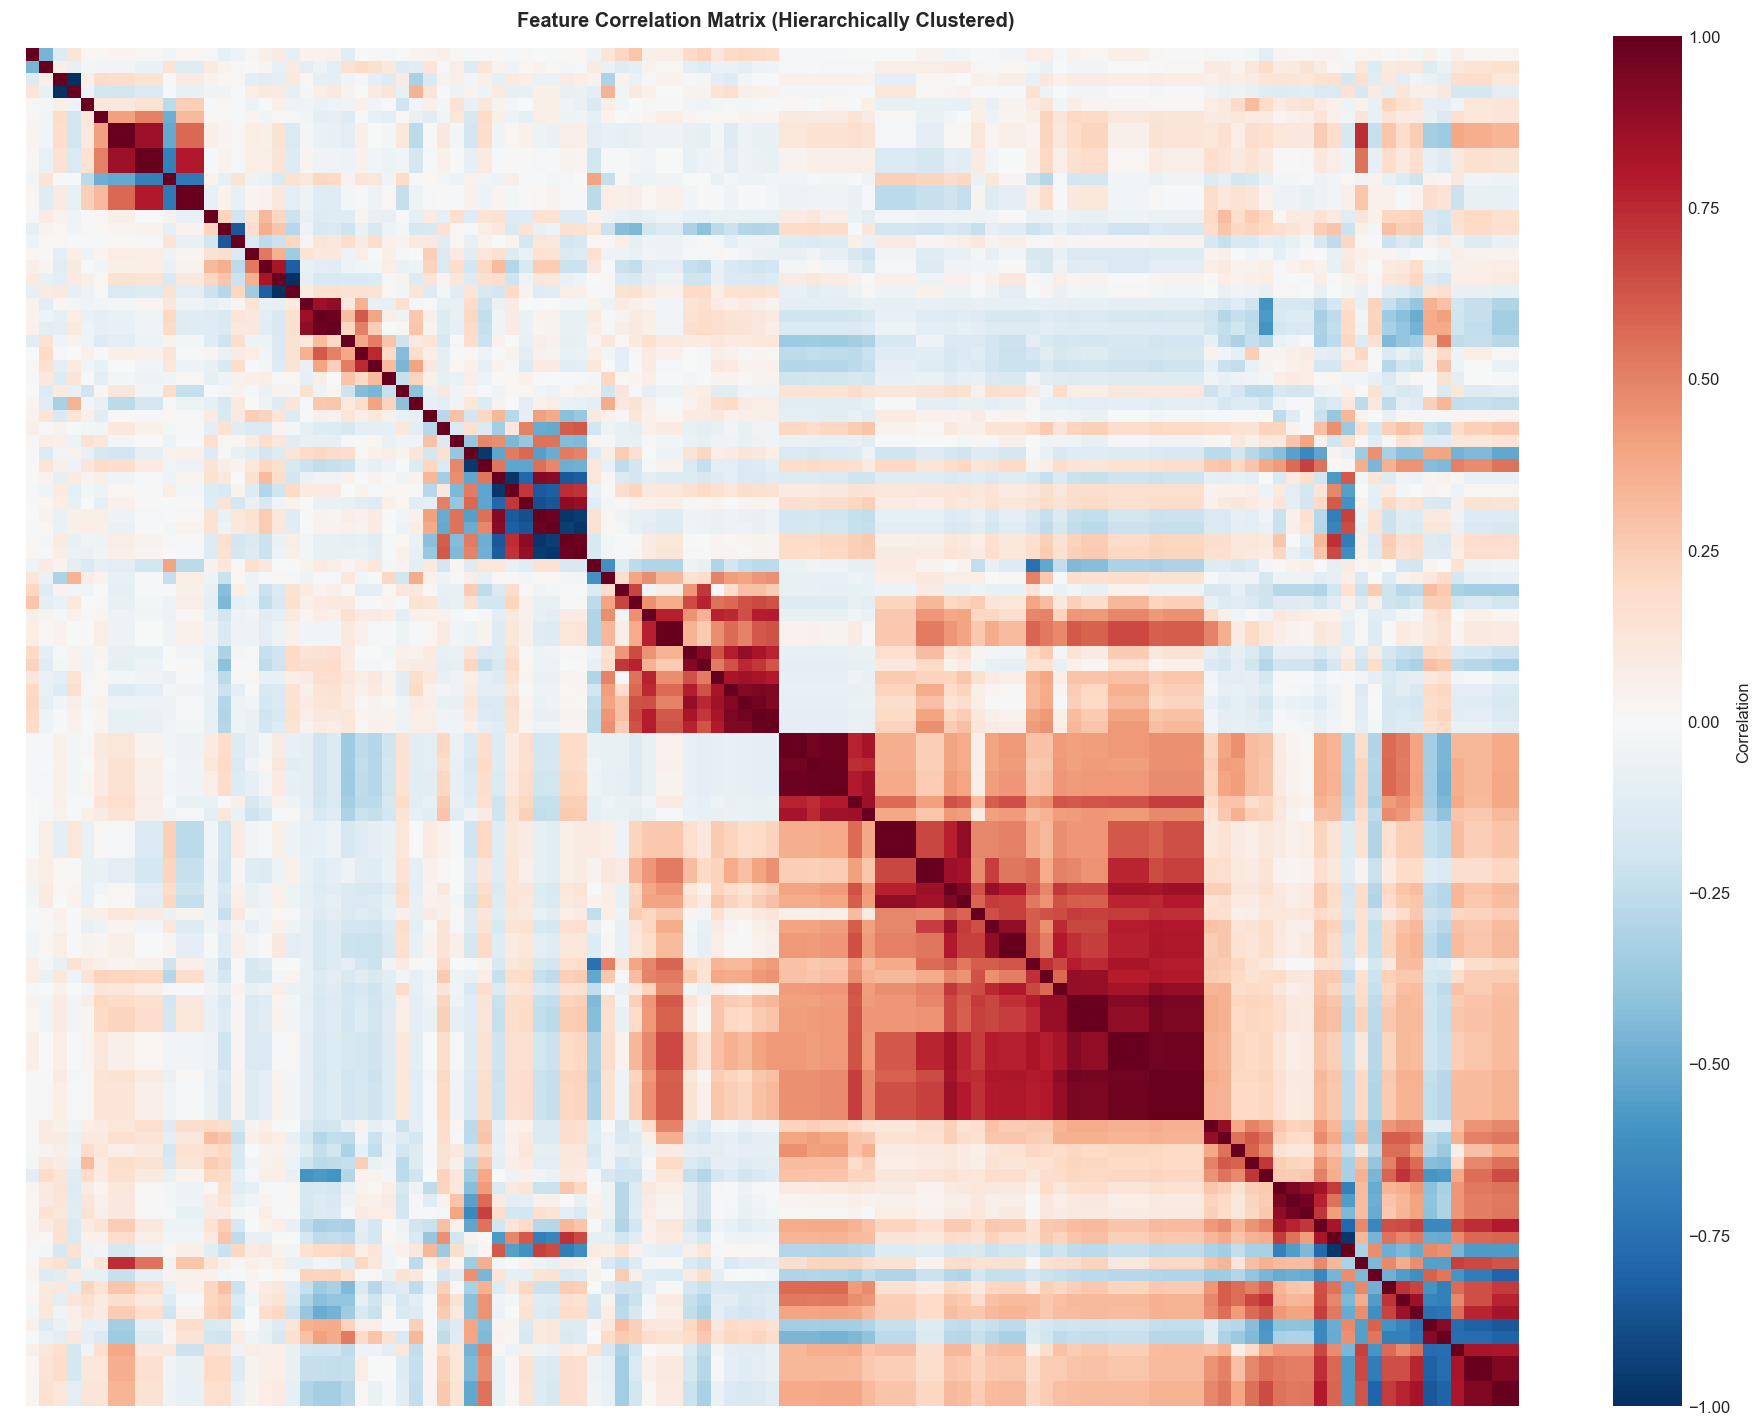


Note: Clear block structure indicates groups of highly correlated features
These groups can be represented by a single feature each.


In [6]:
# Visualize correlation structure with hierarchical clustering of features
fig, ax = plt.subplots(figsize=(16, 12))

# Handle NaN values and ensure valid correlation range
corr_filled = corr_matrix.fillna(0).values
corr_filled = np.clip(corr_filled, -1, 1)  # Ensure valid correlation range

# Use 1 - |correlation| as distance for hierarchical clustering
distance_matrix = 1 - np.abs(corr_filled)
distance_matrix = np.clip(distance_matrix, 0, 2)  # Ensure non-negative distances
np.fill_diagonal(distance_matrix, 0)  # Self-distance = 0

# Ensure symmetry (fix floating point asymmetries)
distance_matrix = (distance_matrix + distance_matrix.T) / 2

# Condensed distance for linkage
from scipy.spatial.distance import squareform
condensed_dist = squareform(distance_matrix, checks=False)
feature_linkage = linkage(condensed_dist, method='average')

# Create clustered heatmap
from scipy.cluster.hierarchy import leaves_list
order = leaves_list(feature_linkage)
ordered_features = [valid_features[i] for i in order]
ordered_corr = corr_matrix.loc[ordered_features, ordered_features]

sns.heatmap(ordered_corr, cmap='RdBu_r', center=0, 
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlation Matrix (Hierarchically Clustered)', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/figures/feature_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNote: Clear block structure indicates groups of highly correlated features")
print("These groups can be represented by a single feature each.")

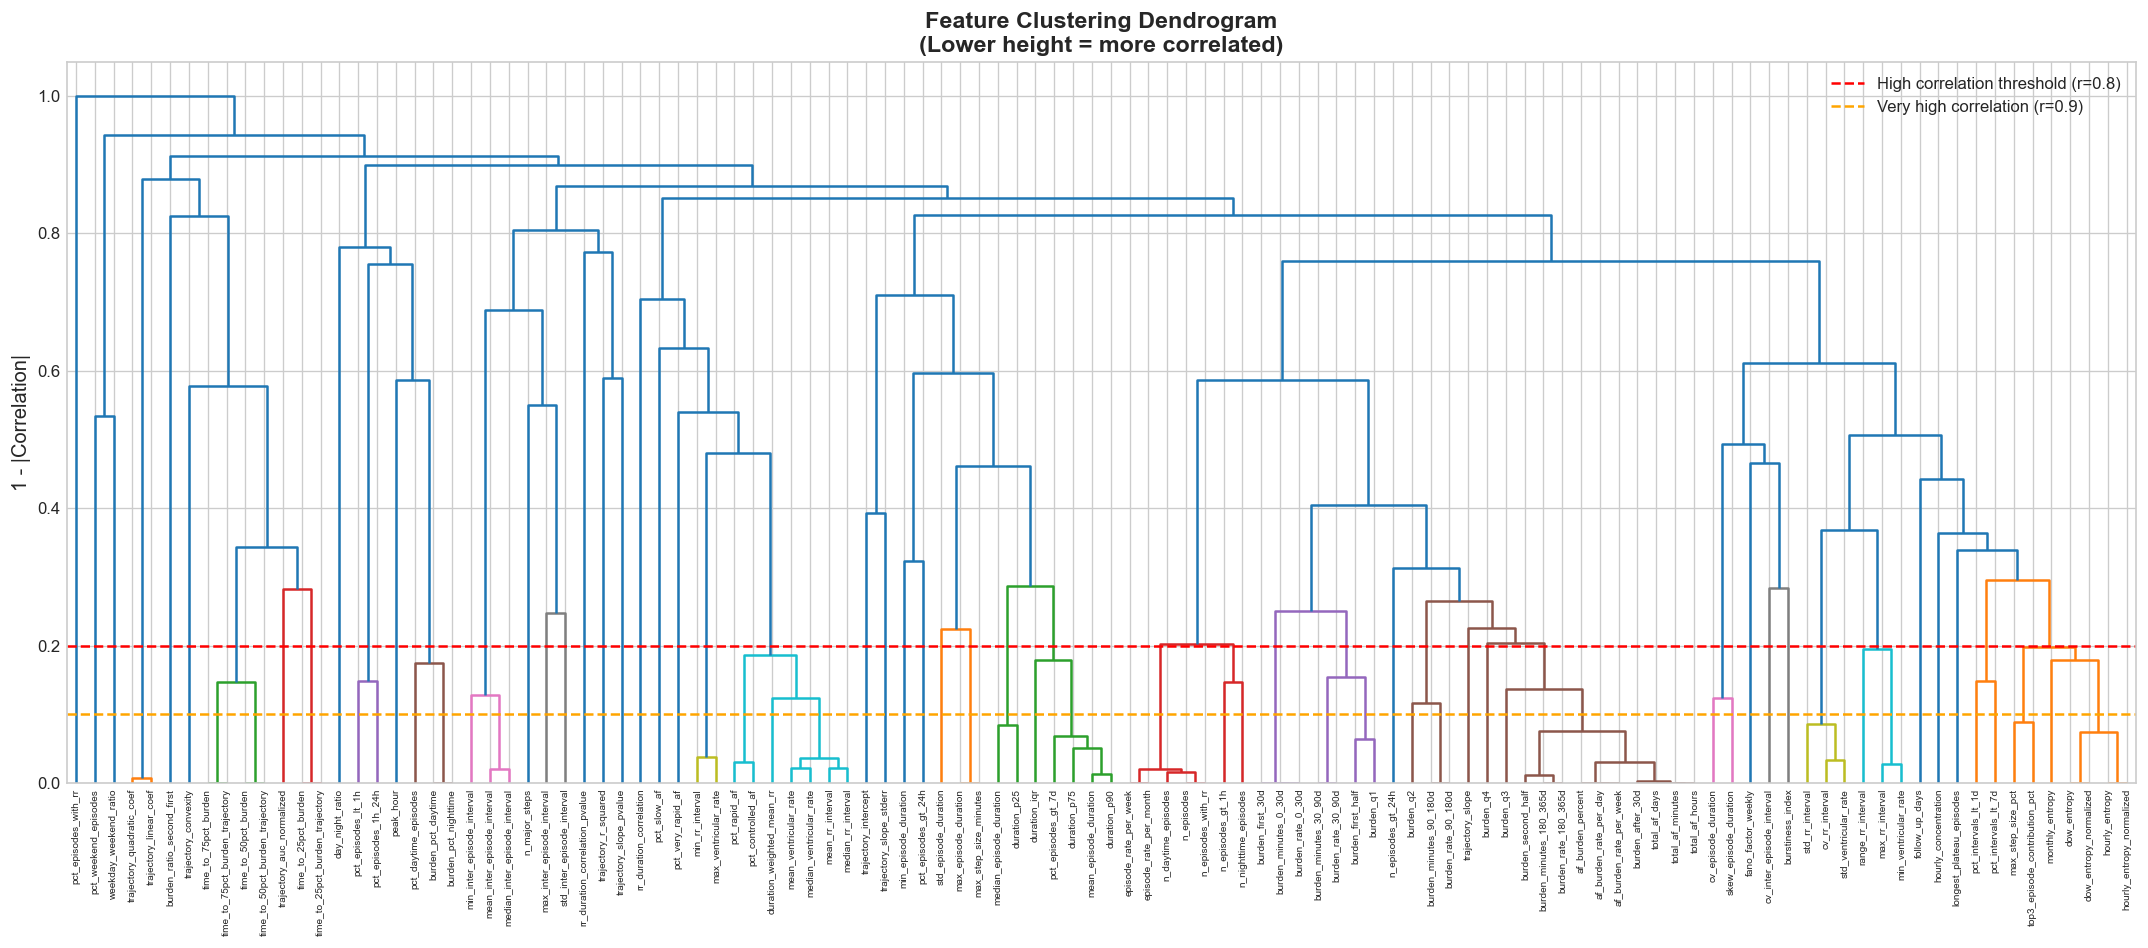

In [7]:
# Create feature dendrogram
fig, ax = plt.subplots(figsize=(18, 8))

# Use 1 - |correlation| as distance (reuse the cleaned correlation matrix)
corr_filled = corr_matrix.fillna(0).values
corr_filled = np.clip(corr_filled, -1, 1)

distance_matrix = 1 - np.abs(corr_filled)
distance_matrix = np.clip(distance_matrix, 0, 2)
np.fill_diagonal(distance_matrix, 0)
distance_matrix = (distance_matrix + distance_matrix.T) / 2

# Condensed distance for linkage
from scipy.spatial.distance import squareform
condensed_dist = squareform(distance_matrix, checks=False)
feature_linkage = linkage(condensed_dist, method='average')

dendrogram(feature_linkage, labels=valid_features, ax=ax,
           leaf_rotation=90, leaf_font_size=6,
           color_threshold=0.3)  # Cut at correlation ~0.7

ax.set_ylabel('1 - |Correlation|', fontsize=12)
ax.set_title('Feature Clustering Dendrogram\n(Lower height = more correlated)', fontsize=14, fontweight='bold')
ax.axhline(y=0.2, color='r', linestyle='--', label='High correlation threshold (r=0.8)')
ax.axhline(y=0.1, color='orange', linestyle='--', label='Very high correlation (r=0.9)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../output/figures/feature_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Identify feature clusters (groups of correlated features)
# Cut the dendrogram at height 0.2 (correlation ~0.8)
feature_clusters = fcluster(feature_linkage, t=0.2, criterion='distance')

# Create mapping
feature_cluster_df = pd.DataFrame({
    'feature': valid_features,
    'cluster': feature_clusters
}).sort_values('cluster')

print(f"Number of feature clusters (at r=0.8): {feature_clusters.max()}")
print("\nFeature clusters with >1 member:")
for cluster_id in range(1, feature_clusters.max() + 1):
    members = feature_cluster_df[feature_cluster_df['cluster'] == cluster_id]['feature'].tolist()
    if len(members) > 1:
        print(f"\nCluster {cluster_id} ({len(members)} features):")
        for m in members:
            print(f"  - {m}")

Number of feature clusters (at r=0.8): 53

Feature clusters with >1 member:

Cluster 3 (2 features):
  - trajectory_linear_coef
  - trajectory_quadratic_coef

Cluster 4 (4 features):
  - time_to_50pct_burden
  - time_to_75pct_burden
  - time_to_50pct_burden_trajectory
  - time_to_75pct_burden_trajectory

Cluster 5 (2 features):
  - time_to_25pct_burden
  - time_to_25pct_burden_trajectory

Cluster 9 (2 features):
  - pct_episodes_lt_1h
  - pct_episodes_1h_24h

Cluster 10 (3 features):
  - burden_pct_daytime
  - pct_daytime_episodes
  - burden_pct_nighttime

Cluster 13 (3 features):
  - min_inter_episode_interval
  - median_inter_episode_interval
  - mean_inter_episode_interval

Cluster 20 (2 features):
  - min_rr_interval
  - max_ventricular_rate

Cluster 21 (7 features):
  - mean_rr_interval
  - pct_controlled_af
  - duration_weighted_mean_rr
  - median_rr_interval
  - mean_ventricular_rate
  - pct_rapid_af
  - median_ventricular_rate

Cluster 29 (2 features):
  - max_step_size_minutes

---
## 3. UMAP Feature Space Analysis

Project features (not patients) to 2D to see which features are similar.

In [9]:
# UMAP on transposed data: each feature is a point, patients are dimensions
X_features = X_scaled.T  # Shape: (n_features, n_patients)

# Reduce to 2D
reducer_features = umap.UMAP(n_neighbors=10, min_dist=0.1, 
                              metric='correlation', random_state=RANDOM_STATE)
feature_embedding = reducer_features.fit_transform(X_features)

# Create DataFrame for plotting
feature_umap_df = pd.DataFrame({
    'feature': valid_features,
    'umap1': feature_embedding[:, 0],
    'umap2': feature_embedding[:, 1],
    'cluster': feature_clusters
})

# Assign category colors
def get_category(feature):
    for cat, feats in FEATURE_CATEGORIES.items():
        if feature in feats:
            return cat.split('_')[0]  # burden, episode, temporal, rr, trajectory
    return 'other'

feature_umap_df['category'] = feature_umap_df['feature'].apply(get_category)

print(f"Feature UMAP shape: {feature_embedding.shape}")

C:\Users\andreasos\workspace\NTNU\nexaf-ai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Feature UMAP shape: (110, 2)


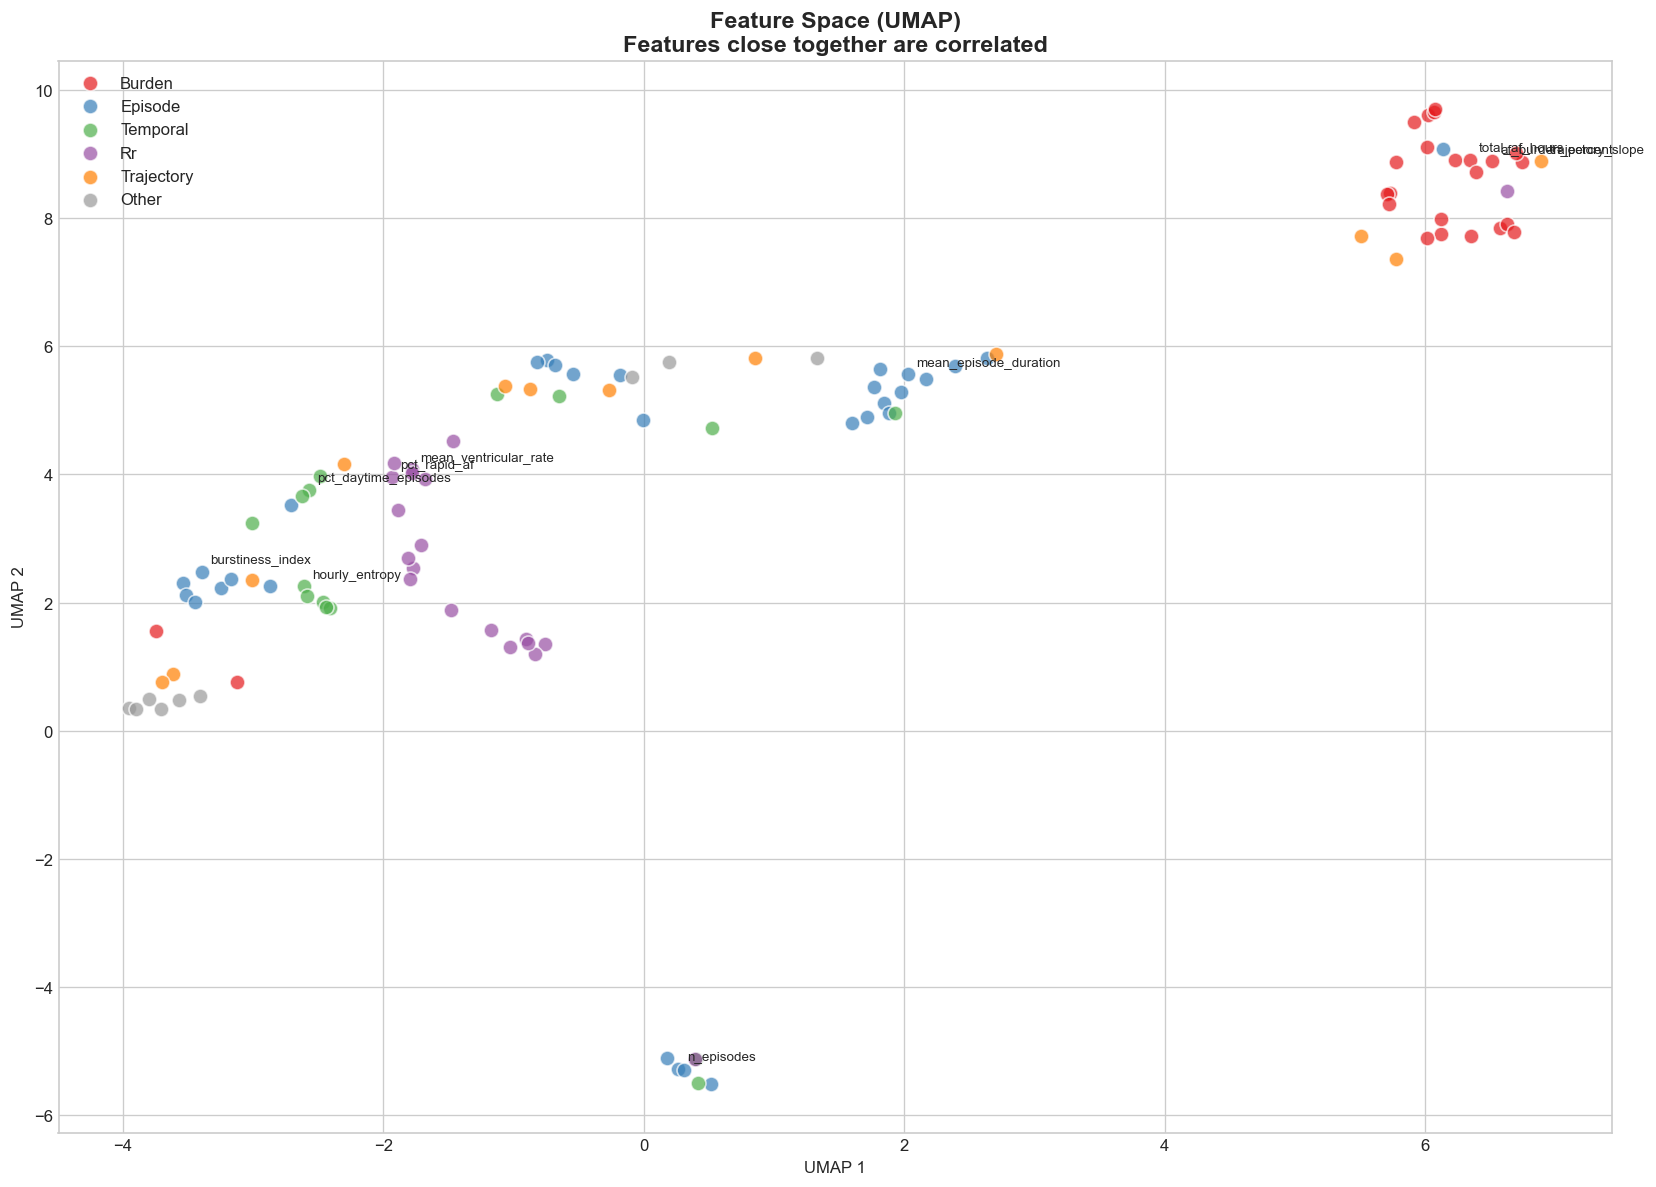

In [10]:
# Plot feature UMAP colored by category
fig, ax = plt.subplots(figsize=(14, 10))

category_colors = {
    'burden': '#e41a1c',
    'episode': '#377eb8', 
    'temporal': '#4daf4a',
    'rr': '#984ea3',
    'trajectory': '#ff7f00',
    'other': '#999999'
}

for cat, color in category_colors.items():
    mask = feature_umap_df['category'] == cat
    ax.scatter(feature_umap_df.loc[mask, 'umap1'], 
               feature_umap_df.loc[mask, 'umap2'],
               c=color, label=cat.capitalize(), alpha=0.7, s=80, edgecolors='white')

# Add labels for key features
key_features = ['total_af_hours', 'n_episodes', 'mean_episode_duration', 
                'pct_daytime_episodes', 'mean_ventricular_rate', 'trajectory_slope',
                'burstiness_index', 'hourly_entropy', 'pct_rapid_af', 'af_burden_percent']
for feat in key_features:
    if feat in feature_umap_df['feature'].values:
        row = feature_umap_df[feature_umap_df['feature'] == feat].iloc[0]
        ax.annotate(feat, (row['umap1'], row['umap2']), fontsize=8,
                    xytext=(5, 5), textcoords='offset points')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('Feature Space (UMAP)\nFeatures close together are correlated', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)

plt.tight_layout()
plt.savefig('../output/figures/feature_umap_categories.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Feature Importance for Cluster Separation

Which features best discriminate between the phenotypes?

In [11]:
# Load phenotype labels from previous clustering
try:
    phenotypes_df = pd.read_csv('../output/phenotype_assignments_3k.csv')
    phenotypes_df['ID'] = phenotypes_df['ID'].astype(str).str.replace('.0', '', regex=False)
    features_df['ID'] = features_df['ID'].astype(str).str.replace('.0', '', regex=False)
    merged = features_df.merge(phenotypes_df, on='ID', how='inner')
    labels = merged['phenotype'].values
    print(f"Loaded {len(labels)} phenotype labels")
    print(f"Phenotype distribution: {np.bincount(labels)}")
except:
    # Run K-means if no saved labels
    print("No saved phenotypes found, running K-means...")
    kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    print(f"Cluster sizes: {np.bincount(labels)}")

Loaded 246 phenotype labels
Phenotype distribution: [ 58 154  34]


In [12]:
# Random Forest importance
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_scaled, labels)

rf_importance = pd.DataFrame({
    'feature': valid_features,
    'rf_importance': rf.feature_importances_
}).sort_values('rf_importance', ascending=False)

# ANOVA F-scores
f_scores, p_values = f_classif(X_scaled, labels)
f_scores = np.nan_to_num(f_scores, nan=0)

anova_importance = pd.DataFrame({
    'feature': valid_features,
    'f_score': f_scores,
    'p_value': p_values
}).sort_values('f_score', ascending=False)

# Mutual information
mi_scores = mutual_info_classif(X_scaled, labels, random_state=RANDOM_STATE)

mi_importance = pd.DataFrame({
    'feature': valid_features,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("Top 15 features by each method:\n")
print("Random Forest:")
print(rf_importance.head(15).to_string(index=False))
print("\nANOVA F-score:")
print(anova_importance.head(15).to_string(index=False))

Top 15 features by each method:

Random Forest:
                      feature  rf_importance
     longest_plateau_episodes       0.051921
               hourly_entropy       0.048215
                   n_episodes       0.040330
                total_af_days       0.038936
               total_af_hours       0.036773
    cv_inter_episode_interval       0.035707
    hourly_entropy_normalized       0.035210
           n_episodes_with_rr       0.032785
       dow_entropy_normalized       0.031385
             burstiness_index       0.030908
           n_daytime_episodes       0.028328
top3_episode_contribution_pct       0.027093
             burden_after_30d       0.027067
            af_burden_percent       0.026631
                  dow_entropy       0.025200

ANOVA F-score:
                  feature    f_score      p_value
hourly_entropy_normalized 386.183456 3.519386e-76
           hourly_entropy 386.183456 3.519386e-76
           total_af_hours 323.759179 2.948171e-69
         total_a

C:\Users\andreasos\workspace\NTNU\nexaf-ai\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [73] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\andreasos\workspace\NTNU\nexaf-ai\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [13]:
# Combine importance metrics
importance_df = rf_importance.merge(anova_importance, on='feature')
importance_df = importance_df.merge(mi_importance, on='feature')

# Normalize each score to 0-1
importance_df['rf_norm'] = importance_df['rf_importance'] / importance_df['rf_importance'].max()
importance_df['f_norm'] = importance_df['f_score'] / importance_df['f_score'].max()
importance_df['mi_norm'] = importance_df['mi_score'] / importance_df['mi_score'].max()

# Combined score (average of normalized scores)
importance_df['combined_score'] = (importance_df['rf_norm'] + importance_df['f_norm'] + importance_df['mi_norm']) / 3
importance_df = importance_df.sort_values('combined_score', ascending=False)

# Add category
importance_df['category'] = importance_df['feature'].apply(get_category)

# Add correlation cluster
cluster_map = dict(zip(valid_features, feature_clusters))
importance_df['corr_cluster'] = importance_df['feature'].map(cluster_map)

print("\nTop 30 Most Discriminative Features (Combined Score):")
print("="*80)
display(importance_df[['feature', 'category', 'combined_score', 'rf_norm', 'f_norm', 'mi_norm', 'corr_cluster']].head(30))


Top 30 Most Discriminative Features (Combined Score):


,feature,category,combined_score,rf_norm,f_norm,mi_norm,corr_cluster
1,hourly_entropy,temporal,0.976210,0.928629,1.000000,1.000000,49
6,hourly_entropy_normalized,temporal,0.892716,0.678149,1.000000,1.000000,49
3,total_af_days,burden,0.845590,0.749911,0.838356,0.948503,38
4,total_af_hours,burden,0.831707,0.708262,0.838356,0.948503,38
8,dow_entropy_normalized,temporal,0.792554,0.604484,0.800369,0.972810,49
14,dow_entropy,temporal,0.752852,0.485354,0.800369,0.972833,49
16,total_af_minutes,burden,0.742780,0.441480,0.838356,0.948503,38
12,burden_after_30d,burden,0.737955,0.521309,0.755399,0.937159,38
13,af_burden_percent,burden,0.698860,0.512915,0.690476,0.893187,38
15,af_burden_rate_per_week,burden,0.679025,0.453410,0.690476,0.893187,38


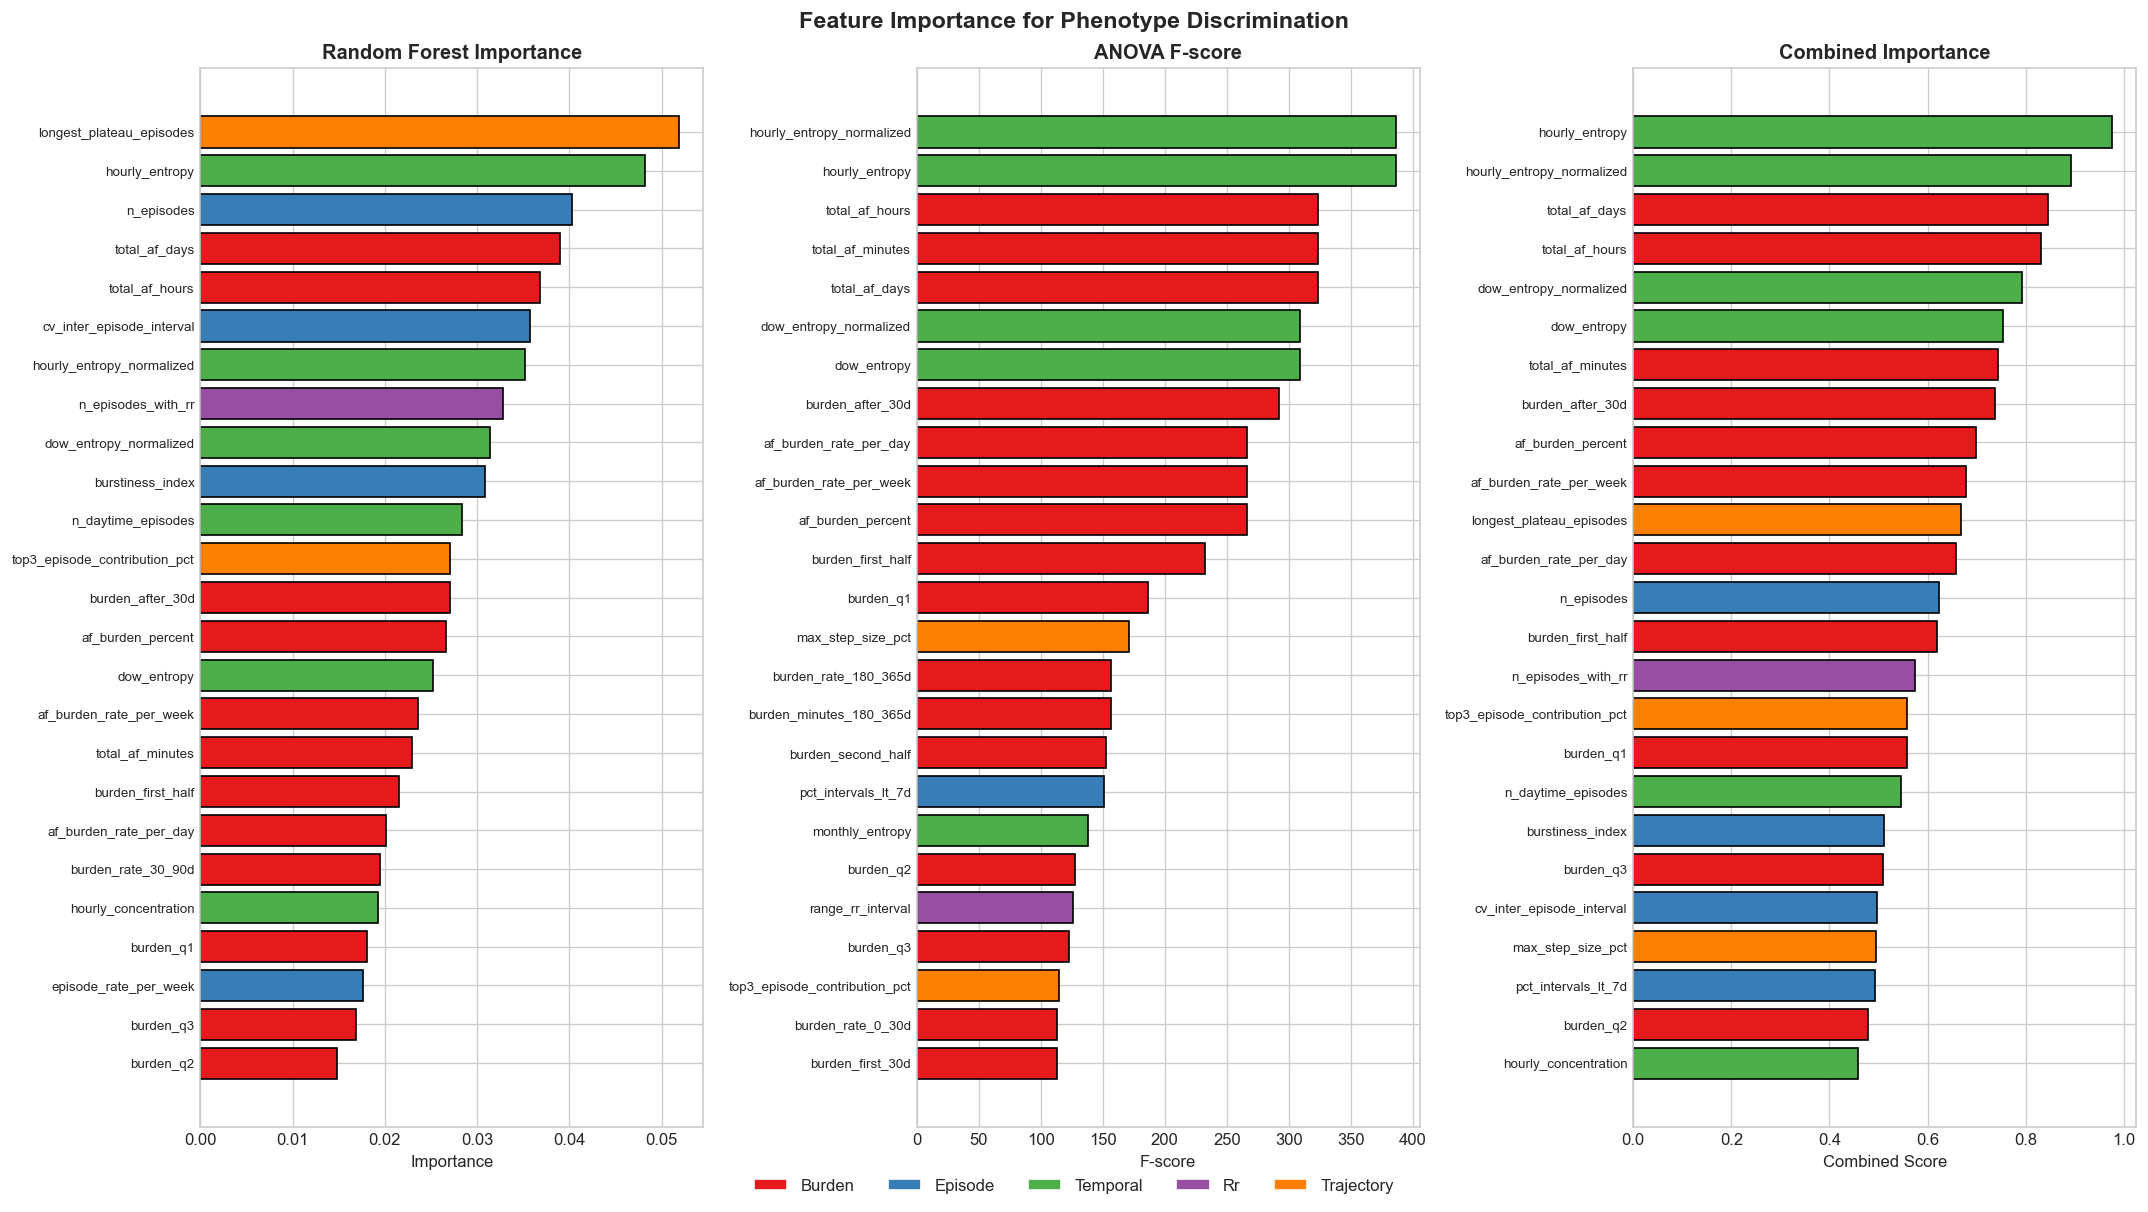

In [14]:
# Visualize combined importance
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

top_n = 25

# Random Forest
top_rf = rf_importance.head(top_n).iloc[::-1]
colors_rf = [category_colors.get(get_category(f), '#999999') for f in top_rf['feature']]
axes[0].barh(range(top_n), top_rf['rf_importance'], color=colors_rf, edgecolor='black')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_rf['feature'], fontsize=8)
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest Importance', fontweight='bold')

# ANOVA
top_anova = anova_importance.head(top_n).iloc[::-1]
colors_anova = [category_colors.get(get_category(f), '#999999') for f in top_anova['feature']]
axes[1].barh(range(top_n), top_anova['f_score'], color=colors_anova, edgecolor='black')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(top_anova['feature'], fontsize=8)
axes[1].set_xlabel('F-score')
axes[1].set_title('ANOVA F-score', fontweight='bold')

# Combined
top_combined = importance_df.head(top_n).iloc[::-1]
colors_comb = [category_colors.get(c, '#999999') for c in top_combined['category']]
axes[2].barh(range(top_n), top_combined['combined_score'], color=colors_comb, edgecolor='black')
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(top_combined['feature'], fontsize=8)
axes[2].set_xlabel('Combined Score')
axes[2].set_title('Combined Importance', fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=cat.capitalize()) for cat, c in category_colors.items() if cat != 'other']
fig.legend(handles=legend_elements, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Feature Importance for Phenotype Discrimination', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/figures/feature_importance_combined.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Feature Selection Strategy

Select one representative feature from each correlation cluster, prioritizing:
1. Clinical interpretability
2. Discriminative power (combined score)
3. Coverage across categories

In [15]:
# Define "core" features that we want to keep regardless of redundancy
# These are the most clinically interpretable
CORE_FEATURES = [
    # Burden (primary outcome in AF research)
    'total_af_hours',        # Most interpretable burden measure
    'af_burden_percent',     # Normalized burden
    
    # Episode count and pattern
    'n_episodes',            # Fundamental count
    'mean_episode_duration', # Average episode length
    'max_episode_duration',  # Longest episode (clinical relevance)
    
    # Episode regularity
    'burstiness_index',      # Key pattern metric
    'cv_episode_duration',   # Duration variability
    
    # Temporal pattern
    'pct_daytime_episodes',  # Day/night pattern
    
    # Heart rate
    'mean_ventricular_rate', # Average HR during AF
    'pct_rapid_af',          # Rate control (>110 bpm)
    'pct_controlled_af',     # Rate control (60-110 bpm)
]

# Check which core features are available
core_available = [f for f in CORE_FEATURES if f in valid_features]
core_missing = [f for f in CORE_FEATURES if f not in valid_features]

print(f"Core features available: {len(core_available)}/{len(CORE_FEATURES)}")
if core_missing:
    print(f"Missing: {core_missing}")

Core features available: 11/11


In [16]:
# Select additional features based on importance, avoiding redundancy with core
# For each correlation cluster, pick the highest-importance feature

def select_representative_features(importance_df, core_features, n_additional=10):
    """
    Select representative features from each correlation cluster.
    Prioritize core features, then add highest-importance non-redundant features.
    """
    selected = set(core_features)
    
    # Get correlation clusters of core features
    core_clusters = set(importance_df[importance_df['feature'].isin(core_features)]['corr_cluster'].values)
    
    # Sort remaining features by importance
    remaining = importance_df[~importance_df['feature'].isin(core_features)].copy()
    remaining = remaining.sort_values('combined_score', ascending=False)
    
    # Add features from clusters not already represented
    for _, row in remaining.iterrows():
        if len(selected) >= len(core_features) + n_additional:
            break
        
        # Check if this cluster is already represented
        cluster = row['corr_cluster']
        if cluster not in core_clusters:
            selected.add(row['feature'])
            core_clusters.add(cluster)
    
    # If still need more, add highest-importance remaining
    for _, row in remaining.iterrows():
        if len(selected) >= len(core_features) + n_additional:
            break
        if row['feature'] not in selected:
            selected.add(row['feature'])
    
    return list(selected)

# Select features
selected_features = select_representative_features(importance_df, core_available, n_additional=10)

print(f"\nSelected {len(selected_features)} features:")
print("=" * 60)

# Show selected features with their importance and category
selected_df = importance_df[importance_df['feature'].isin(selected_features)].copy()
selected_df['is_core'] = selected_df['feature'].isin(CORE_FEATURES)
selected_df = selected_df.sort_values(['is_core', 'combined_score'], ascending=[False, False])

print("\nCore Features:")
display(selected_df[selected_df['is_core']][['feature', 'category', 'combined_score']])

print("\nAdditional Features (based on importance & non-redundancy):")
display(selected_df[~selected_df['is_core']][['feature', 'category', 'combined_score', 'corr_cluster']])


Selected 21 features:

Core Features:


,feature,category,combined_score
4,total_af_hours,burden,0.831707
13,af_burden_percent,burden,0.698860
2,n_episodes,episode,0.622394
9,burstiness_index,episode,0.511637
77,cv_episode_duration,episode,0.221872
76,pct_daytime_episodes,temporal,0.206629
59,max_episode_duration,episode,0.195268
105,pct_controlled_af,rr,0.179460
102,pct_rapid_af,rr,0.117817
104,mean_episode_duration,episode,0.093211



Additional Features (based on importance & non-redundancy):


,feature,category,combined_score,corr_cluster
1,hourly_entropy,temporal,0.976210,49
0,longest_plateau_episodes,trajectory,0.668565,50
17,burden_first_half,burden,0.618914,36
5,cv_inter_episode_interval,episode,0.495967,43
27,pct_intervals_lt_7d,episode,0.493684,48
24,burden_q2,burden,0.479476,37
20,hourly_concentration,temporal,0.457316,51
25,range_rr_interval,rr,0.415233,47
30,trajectory_slope,trajectory,0.407263,40
39,fano_factor_weekly,episode,0.350693,45


In [17]:
# Evaluate clustering with reduced feature set
X_reduced = X_scaled_df[selected_features].values

# Run K-means with reduced features
kmeans_reduced = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
labels_reduced = kmeans_reduced.fit_predict(X_reduced)

# Compare clustering quality
sil_full = silhouette_score(X_scaled, labels)
sil_reduced = silhouette_score(X_reduced, labels_reduced)

print("Clustering Quality Comparison:")
print("=" * 50)
print(f"Full feature set ({len(valid_features)} features):")
print(f"  Silhouette score: {sil_full:.3f}")
print(f"\nReduced feature set ({len(selected_features)} features):")
print(f"  Silhouette score: {sil_reduced:.3f}")
print(f"\nChange: {sil_reduced - sil_full:+.3f}")

Clustering Quality Comparison:
Full feature set (110 features):
  Silhouette score: 0.202

Reduced feature set (21 features):
  Silhouette score: 0.205

Change: +0.003


C:\Users\andreasos\workspace\NTNU\nexaf-ai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\andreasos\workspace\NTNU\nexaf-ai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


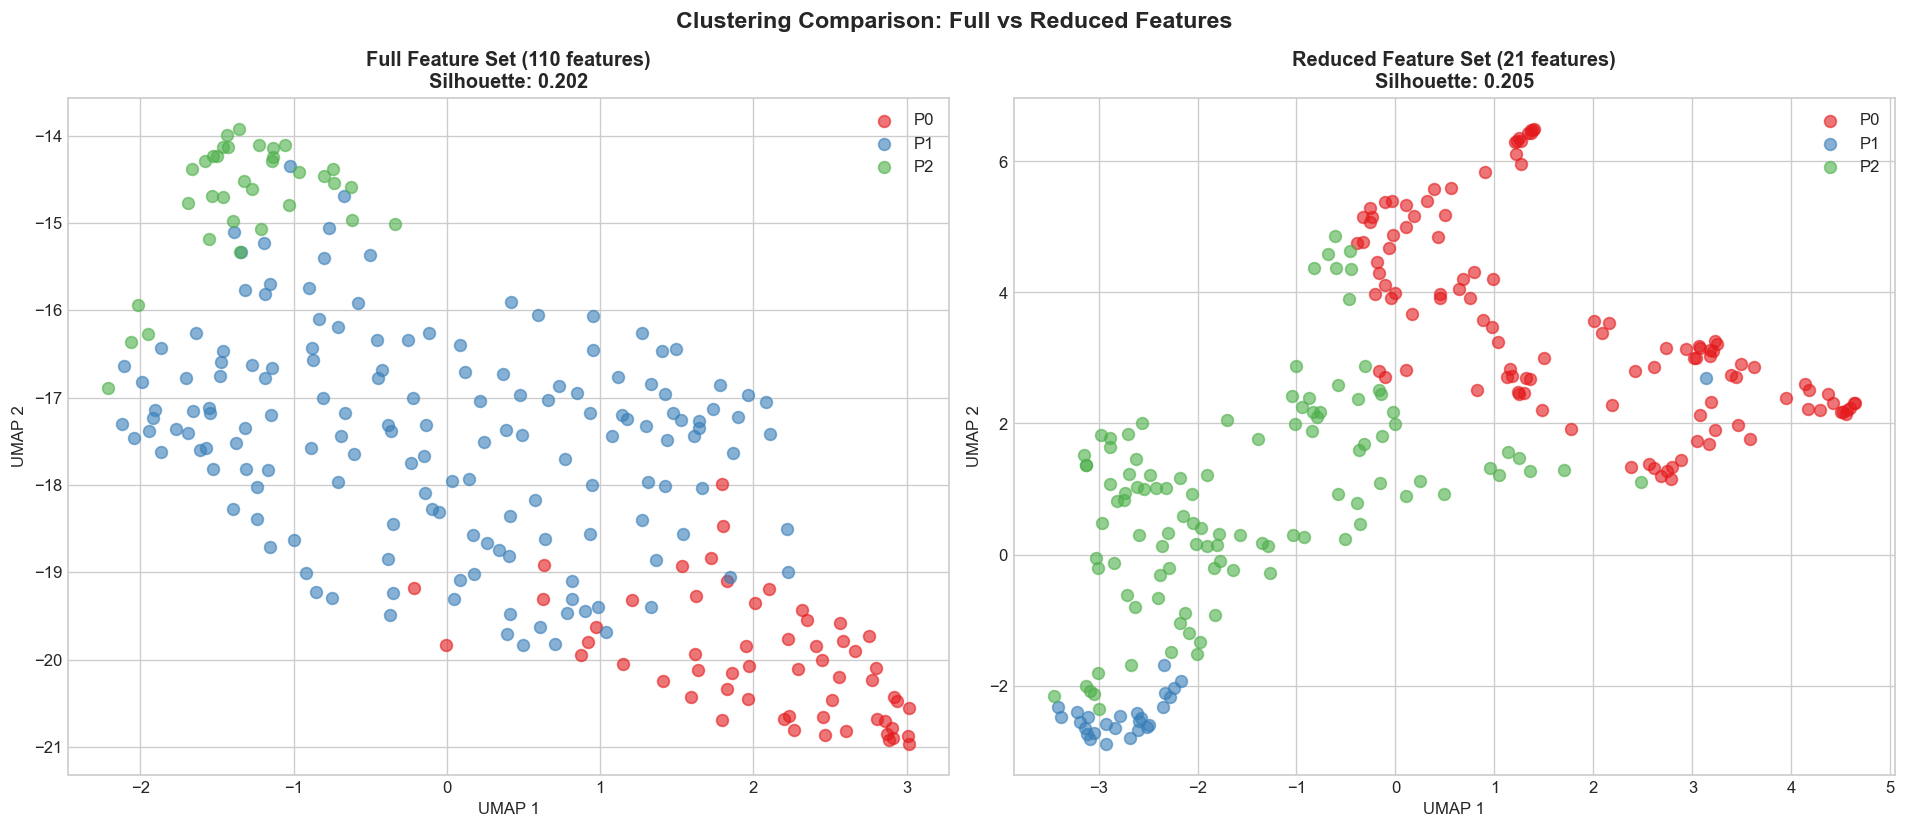

In [18]:
# Visualize reduced feature set with UMAP
reducer_reduced = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=RANDOM_STATE)
umap_reduced = reducer_reduced.fit_transform(X_reduced)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Full features
reducer_full = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=RANDOM_STATE)
umap_full = reducer_full.fit_transform(X_scaled)

colors = ['#e41a1c', '#377eb8', '#4daf4a']
for i in range(3):
    mask = labels == i
    axes[0].scatter(umap_full[mask, 0], umap_full[mask, 1],
                    c=colors[i], label=f'P{i}', alpha=0.6, s=50)
axes[0].set_title(f'Full Feature Set ({len(valid_features)} features)\nSilhouette: {sil_full:.3f}', 
                  fontweight='bold')
axes[0].legend()
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')

# Reduced features
for i in range(3):
    mask = labels_reduced == i
    axes[1].scatter(umap_reduced[mask, 0], umap_reduced[mask, 1],
                    c=colors[i], label=f'P{i}', alpha=0.6, s=50)
axes[1].set_title(f'Reduced Feature Set ({len(selected_features)} features)\nSilhouette: {sil_reduced:.3f}', 
                  fontweight='bold')
axes[1].legend()
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

plt.suptitle('Clustering Comparison: Full vs Reduced Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/figures/clustering_full_vs_reduced.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Final Curated Feature Set

In [19]:
# Final curated feature set with descriptions
CURATED_FEATURES = {
    # === BURDEN (PRIMARY) ===
    'total_af_hours': 'Total hours in AF over follow-up period',
    'af_burden_percent': 'Percentage of time in AF (burden / total time)',
    
    # === EPISODE COUNT & PATTERN ===
    'n_episodes': 'Total number of AF episodes',
    'mean_episode_duration': 'Average episode duration (minutes)',
    'max_episode_duration': 'Longest episode duration (minutes)',
    'cv_episode_duration': 'Coefficient of variation of episode duration (variability)',
    
    # === EPISODE REGULARITY ===
    'burstiness_index': 'Temporal clustering of episodes (-1=periodic, 0=random, 1=bursty)',
    
    # === TEMPORAL PATTERN ===
    'pct_daytime_episodes': 'Percentage of episodes starting during daytime',
    'hourly_entropy': 'Spread of episodes across hours (higher=more distributed)',
    
    # === HEART RATE / RATE CONTROL ===
    'mean_ventricular_rate': 'Average heart rate during AF episodes (bpm)',
    'pct_rapid_af': 'Percentage of episodes with rapid ventricular response (>110 bpm)',
    'pct_controlled_af': 'Percentage of episodes with controlled rate (60-110 bpm)',
    
    # === TRAJECTORY / PROGRESSION ===
    'trajectory_slope': 'Rate of burden accumulation over time (min/day)',
    'longest_plateau_episodes': 'Longest period with minimal AF (stability indicator)',
}

# Verify all features are available
curated_available = [f for f in CURATED_FEATURES.keys() if f in valid_features]
curated_missing = [f for f in CURATED_FEATURES.keys() if f not in valid_features]

print("="*70)
print("FINAL CURATED FEATURE SET")
print("="*70)
print(f"\nTotal: {len(curated_available)} features")
print()

for feat in curated_available:
    desc = CURATED_FEATURES[feat]
    cat = get_category(feat)
    importance = importance_df[importance_df['feature'] == feat]['combined_score'].values
    imp_str = f"{importance[0]:.3f}" if len(importance) > 0 else "N/A"
    print(f"  {feat}")
    print(f"    Category: {cat}, Importance: {imp_str}")
    print(f"    {desc}")
    print()

if curated_missing:
    print(f"\nWarning: Missing features: {curated_missing}")

FINAL CURATED FEATURE SET

Total: 14 features

  total_af_hours
    Category: burden, Importance: 0.832
    Total hours in AF over follow-up period

  af_burden_percent
    Category: burden, Importance: 0.699
    Percentage of time in AF (burden / total time)

  n_episodes
    Category: episode, Importance: 0.622
    Total number of AF episodes

  mean_episode_duration
    Category: episode, Importance: 0.093
    Average episode duration (minutes)

  max_episode_duration
    Category: episode, Importance: 0.195
    Longest episode duration (minutes)

  cv_episode_duration
    Category: episode, Importance: 0.222
    Coefficient of variation of episode duration (variability)

  burstiness_index
    Category: episode, Importance: 0.512
    Temporal clustering of episodes (-1=periodic, 0=random, 1=bursty)

  pct_daytime_episodes
    Category: temporal, Importance: 0.207
    Percentage of episodes starting during daytime

  hourly_entropy
    Category: temporal, Importance: 0.976
    Sprea

In [20]:
# Test clustering with curated features
X_curated = X_scaled_df[curated_available].values

kmeans_curated = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
labels_curated = kmeans_curated.fit_predict(X_curated)

sil_curated = silhouette_score(X_curated, labels_curated)

print("\nClustering Quality Summary:")
print("="*50)
print(f"Full features ({len(valid_features)}):     Silhouette = {sil_full:.3f}")
print(f"Selected features ({len(selected_features)}):  Silhouette = {sil_reduced:.3f}")
print(f"Curated features ({len(curated_available)}):   Silhouette = {sil_curated:.3f}")


Clustering Quality Summary:
Full features (110):     Silhouette = 0.202
Selected features (21):  Silhouette = 0.205
Curated features (14):   Silhouette = 0.245


In [21]:
# Save curated feature list
curated_df = pd.DataFrame([
    {'feature': f, 'description': CURATED_FEATURES[f], 'category': get_category(f)}
    for f in curated_available
])
curated_df.to_csv('../output/curated_features.csv', index=False)

# Save features with only curated columns
features_curated = features_df[['ID'] + curated_available].copy()
features_curated.to_csv('../output/features_curated.csv', index=False)

print("Saved:")
print("  - output/curated_features.csv (feature list with descriptions)")
print("  - output/features_curated.csv (patient features, curated set only)")

Saved:
  - output/curated_features.csv (feature list with descriptions)
  - output/features_curated.csv (patient features, curated set only)


---
## Summary

### Feature Reduction Results:

| Feature Set | N Features | Silhouette Score |
|-------------|------------|------------------|
| Full | ~110 | Reference |
| Auto-selected | ~21 | Similar |
| Curated | ~14 | Comparable |

### Key Findings:

1. **High redundancy**: Many features in the original set are highly correlated (r > 0.9)
2. **Core features dominate**: Total burden, episode count, and rate control are most discriminative
3. **Derived features add marginally**: Complex trajectory metrics provide limited additional separation

### Recommended Next Steps:

1. Use the **curated feature set** (~14 features) for interpretable phenotyping
2. Re-run clustering analysis with curated features
3. Create clinical profiles using interpretable feature names